In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import builtins
builtins.NAMING = "new"

from plotting_src.header_settings import * 
from plotting_src.read_ggp_run import * 
from simulations.cells_simulation import * 

from plotting_src.cells_utils import *
from plotting_src.read_utils import *

from plotting_src.plot_correlations_from_npz import *
import os

%config InlineBackend.figure_format ='retina'

header_setting.py: using new naming


In [2]:
def get_metas(prediction_files):
    prediction_files = sorted(prediction_files)
    samples = pd.DataFrame(index=prediction_files, columns=["date", "sample", "promoter", "condition", "replicate"])
    for pf in prediction_files:
        sample = "_".join(pf.split("/")[-1].split(".")[0].split("_")[:3])
        samples.loc[pf,"sample"] = sample
        samples.loc[pf,"condition"] = sample.split("_")[0]
        samples.loc[pf,"promoter"] = sample.split("_")[1]
        samples.loc[pf,"date"] = sample.split("_")[2]
                
    condition_promoter_tuples = []
    for pf in prediction_files:
        condition_promoter_tuple = "_".join(samples.loc[pf,"sample"].split("_")[:2])
        if condition_promoter_tuple in condition_promoter_tuples:
            samples.loc[pf,"replicate"] = "2"
        else:
            samples.loc[pf,"replicate"] = "1"
        condition_promoter_tuples.append(condition_promoter_tuple)

    return samples.to_dict('index')


def calc_log_concentration(cells):
    for i, cell in enumerate(cells):
        c = cell.gfp/np.exp(cell.log_length)
        if np.any(c<0):
            print(c)
        cells[i].log_concentration = np.log(c)
        cells[i].log1_concentration = np.log(c+1)
        cells[i].concentration = c
    return cells


def get_integration_file(pf, setting):
    parent_dir = os.path.join(*pf.split("/")[:-1])
    sample = '_'.join(pf.split('/')[-1].split('_')[:3])
    return os.path.join(*parent_dir.split("/")[:-1], "integration",sample, setting, sample+"_"+setting+'.csv')


def calc_mean(means, covs=None):
    if np.any(covs==None):
        mean = np.mean(means)
    else:
        mean = np.sum(means/covs) /np.sum(1/covs)
    return mean

def calc_cv(means, covs=None):
    if np.any(covs==None):
        return np.std(means)/np.mean(means)
    else:
        return np.sqrt(np.sum(np.power(means, 2) + covs)/len(means) - np.mean(means)**2)/calc_mean(means)

def calc_std(means, covs=None):
    if np.any(covs==None):
        return np.std(means)
    else:
        return np.sqrt(np.sum(np.power(means, 2) + covs)/len(means) - np.mean(means)**2)

def get_cells(samples):
    
    for pf in samples.keys():

        samples[pf]["parameters"]  = read_header(pf)

        samples[pf]["cells"] = calc_log_concentration(ggp_df2cells(read_ggp_csv(pf)))
        samples[pf]["ggp_cells"] = calc_log_concentration(df2ggp_cells(read_ggp_csv(pf)))

        for i in ["l", "q"]:
            zi = "mean_{:s}".format(i)
            zi_cov = "cov_{:s}{:s}".format(i, i)

            zi_coll_prediction = np.concatenate([cell.__dict__[zi] for cell in samples[pf]["ggp_cells"]])
            zi_coll_prediction_err = np.concatenate([cell.__dict__[zi_cov] for cell in samples[pf]["ggp_cells"]])
            samples[pf]["{:s}_mean".format(i)] = calc_mean(zi_coll_prediction, zi_coll_prediction_err)
            samples[pf]["{:s}_cv".format(i)] = calc_cv(zi_coll_prediction, zi_coll_prediction_err)
            samples[pf]["{:s}_std".format(i)] = calc_std(zi_coll_prediction, zi_coll_prediction_err)

    return samples
        


def get_corr_func(samples):
    for pf in samples.keys():
        cf = pf.replace("_autofl_corrected_", "_rawdata_")
        # cf = cf.replace("_autofl_corrected", "")
        cf = cf.replace("prediction.csv", "correlations.npz")
        data = np.load(cf, allow_pickle=True)
        # print(data)
        samples[pf]["correlation_function"] = Correlation_function(data['correlations'])
    return samples
    
    
def filter_dict(samples, filter_key=None):
    new_samples = {}
    for pf in samples.keys():
        sample_name = pf.split("/")[-1].split("_")
        if filter_key in sample_name:
            new_samples[pf] = samples[pf]
    return new_samples

def filter_dict_not(samples, *filter_keys):
    new_samples = {}
    for pf in samples.keys():
        sample_name = pf.split("/")[-1].split("_")
        remove = np.any([filter_key in sample_name for filter_key in filter_keys])
        if not remove:
            new_samples[pf] = samples[pf]
    return new_samples

def get_replicate(samples, repl="1"):
    new_samples = {}
    for pf in samples.keys():
        
        if samples[pf]["replicate"] == repl :
            new_samples[pf] = samples[pf]
    return new_samples

repl_prediction_files = get_input_files("../../fluctuations_paper_data/replicates_hi1_rrnB/",
                                        keyword="prediction")

prediction_files = get_input_files("../../fluctuations_paper_data/mother_machine_data_sets/",
                                        keyword="prediction")

prediction_files = [pf for pf in prediction_files if "hi1" in pf or "rrnB" in pf]
all_pred_files = repl_prediction_files + prediction_files

samples = get_metas(all_pred_files)

samples = get_corr_func(samples)
samples = get_cells(samples)
replicates = get_corr_func(samples)

## Cross corr

Saved in ../../figures_for_fluctuations_paper/supp/cross_corr_replicate.pdf


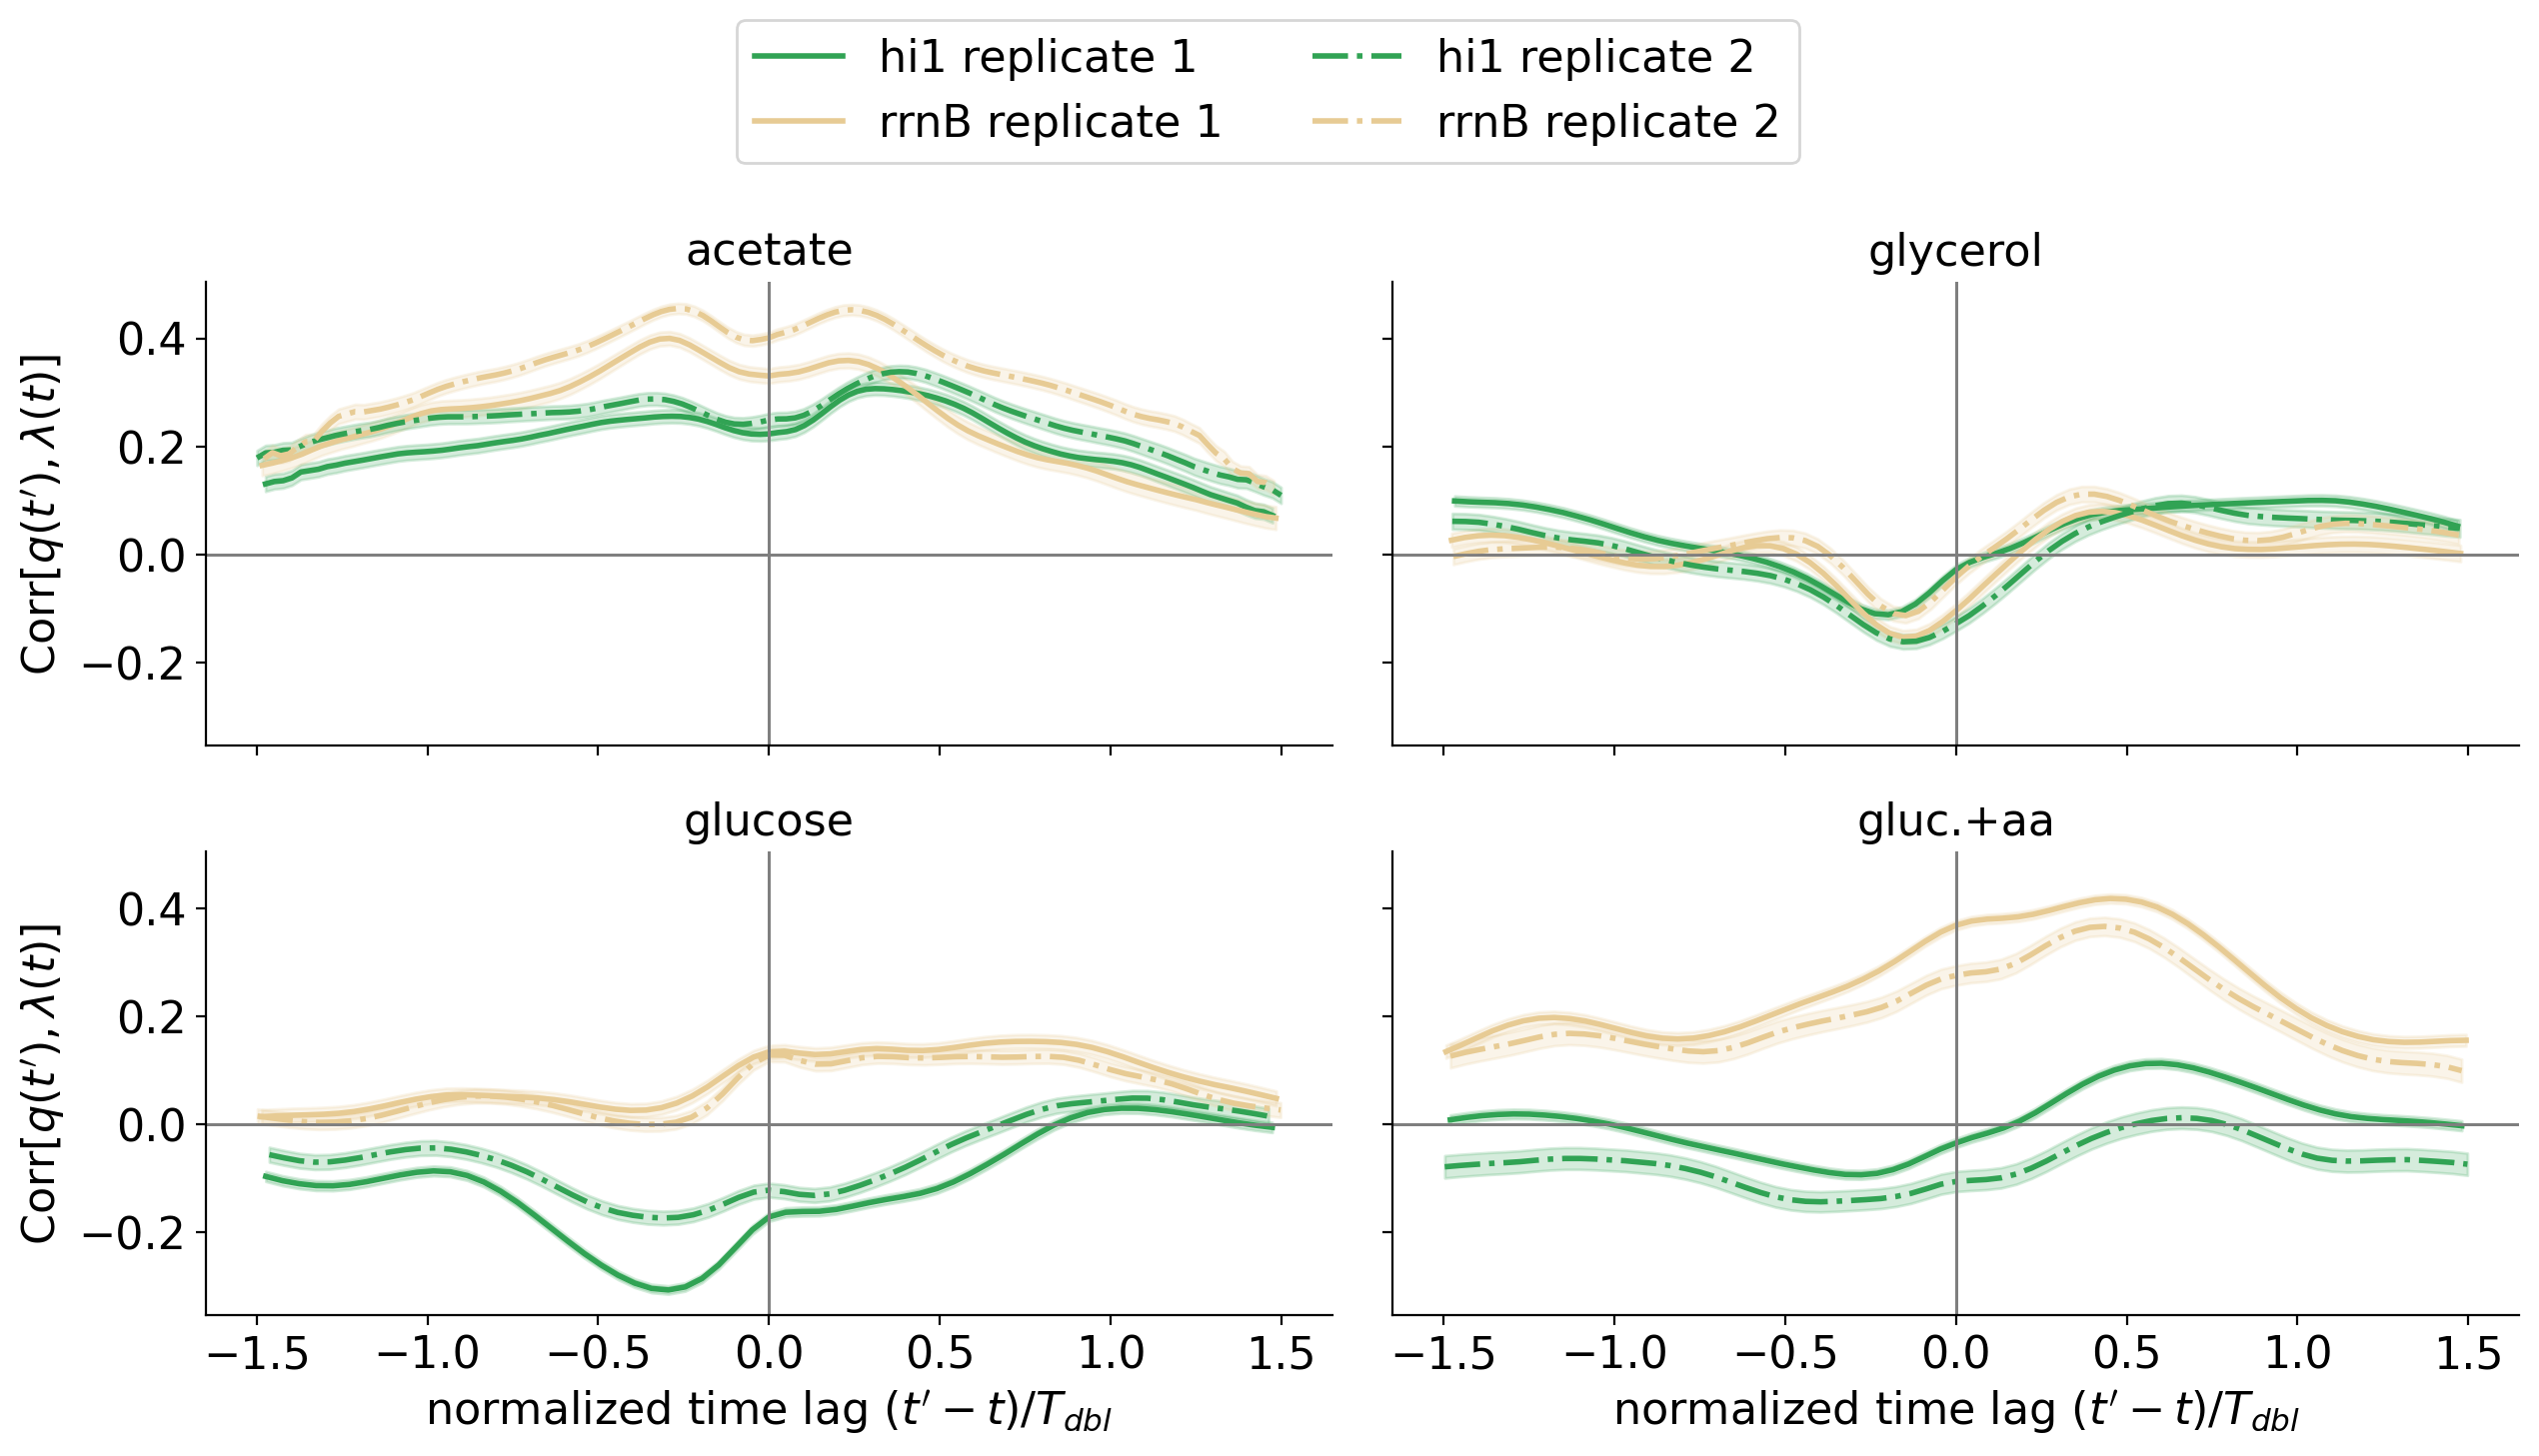

In [3]:
def plot_cross_coor(samples, x, y, 
                    plot_file=None, 
                    normalize=None,
                    xlim=[None, None],
                    ylim=[None,None], 
                    ylabel=None,
                    log=False, 
                    fit=False, 
                    highlight_x0=False,
                    highlight_y0=False,
                    corr_type="cov", 
                    color_by="condition",
                    legend=True,
                    title=None):


    get_func=Correlation_function.get_corr_mle
    get_err_func=Correlation_function.get_corr_mle_err

    # =========== figure =========== #

    fig, ax = plt.subplots(2, 2, figsize=(FULL_SIZE, FULL_SIZE/2), sharey=True, sharex=True)
    ax = ax.ravel()

    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)
        # set the x-spine
#         ax.spines['left'].set_position('zero')

        # turn off the right spine/ticks
        a.spines['right'].set_color('none')
        a.yaxis.tick_left()

    # =========== plot =========== #
    corr_at_mdt = {c:[] for c in conditions}

    for i, condition in enumerate(conditions):
        for j, sample in enumerate(samples.keys()):
            if samples[sample]["condition"] != condition:
                continue
            
            correlation_function = copy.deepcopy(samples[sample]['correlation_function'])
            correlation_function.filter_by_n(100)
                        
            # =========== correlation =========== #
            dts = correlation_function.dt
            rs = get_func(correlation_function, x,y)
            errs = get_err_func(correlation_function, x,y)


            gamma_lambda = samples[sample]["parameters"]["gamma_lambda"][1]
                          
            mean_lambda = samples[sample]["l_mean"]
            promoter = samples[sample]["promoter"]
            
            dts /= (np.log(2.)/mean_lambda)
            gamma_lambda*=(np.log(2)/mean_lambda)


            if xlim!=[None,None]:
                dt_filter = (dts<=xlim[-1])*(dts>=xlim[0])
                dts=dts[dt_filter]
                rs=rs[dt_filter]
                errs=errs[dt_filter]

            color = color_by_promoter[promoter]
            if samples[sample]["replicate"]=="2":
                ls ="-."
            else:
                ls = "-"
            ax[i].plot(dts, rs, lw=2, color=color, label=promoter+" replicate "+samples[sample]["replicate"],
                       alpha=1, ls=ls)
            ax[i].fill_between(dts, rs-errs*2, rs+errs*2, color=color, alpha=0.2)
            ax[i].set_title(label_by_condition[condition])
            
            ax[i].axhline(0,color="tab:grey", lw=1,)
            ax[i].axvline(0,color="tab:grey", lw=1,)

            ax[i].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))
            ax[i].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.2))
        


    if ylim != [None, None]:
        new_ylim = ylim

    if legend:
        ncol=3
        fig.legend(*legend_without_duplicate_labels(ax[0]), 
                   loc='lower center', bbox_to_anchor=(0.5, 1.), ncol=6)

    ax[0].set_ylabel(ylabel)
    ax[2].set_ylabel(ylabel)
        
    # fig.supxlabel(r'$dt/$(mean doubling time)', y=0.13)
    ax[2].set_xlabel(r'normalized time lag $(t^\prime-t)/T_{dbl}$')
    ax[3].set_xlabel(r'normalized time lag $(t^\prime-t)/T_{dbl}$')
    
                                     
    l = fig.legend(*legend_without_duplicate_labels(ax[0]),
                    bbox_to_anchor=(0.5, 1), 
                    loc="lower center", ncol=2)

    fig.tight_layout()
    if plot_file != None:
        print("Saved in", plot_file)
        fig.savefig(plot_file, dpi=300, facecolor="white", bbox_inches="tight")
        plt.show()
        
    else:
        plt.show()
    plt.close()
            
plot_cross_coor(replicates, 
                        "q(t+dt)", "l(t)", 
                        ylabel=r"Corr$[q(t^\prime),\lambda(t)]$",
                        ylim=[-0.5, 0.5], 
                        xlim=[-1.5,1.5], 
                        # log=True, 
                        corr_type="corr",
                        legend=False, 
                        color_by="condition",
                        title=None,
                        plot_file="../../figures_for_fluctuations_paper/supp/cross_corr_replicate.pdf")


